In [235]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "mtx_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


(3, 3) (1, 5)


In [307]:
# Process image combining color and gradient threshold
def Color_Gradient(img, s_thresh=(170, 255), l_thresh=(220, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

#     b_channel = img[:,:,2]
    l_channel = luv[:,:,0]
    s_channel = hls[:,:,2]
#     h_channel = hls[:,:,0]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
#     # Sobel y
#     sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
#     abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
#     scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
#     # Threshold x gradient
#     sybinary = np.zeros_like(scaled_sobely)
#     sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    
#     # Threshold color channel b
#     b_binary = np.zeros_like(b_channel)
#     b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
#     # Threshold color channel H
#     h_binary = np.zeros_like(h_channel)
#     h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    # Threshold color channel S
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    
    # Threshold color channel L
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel, Green means the contribution from threshold gradient, Blue is from color threshold
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, l_binary|s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(l_binary == 1) | (s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

def Inverse_Warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    inv_warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return inv_warped

def Perspective_Transform(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def Find_Window_Regular(binary_warped, nwindows = 9, margin = 100):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    warped_image = out_img

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, right_lane_inds, left_fit, right_fit

def Find_Line(binary_warped, left_fit, right_fit, margin = 100):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, right_lane_inds, left_fit, right_fit

def Sanity_Check(binary_warped, left_fit, right_fit, threshold=200):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    correct_distance = rightx_base - leftx_base
    
    # Generate x and y values for comparision in both detected lanes
    ploty = np.linspace(0, binary_warped.shape[0], 20 )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    distance = np.absolute(right_fitx - left_fitx)
    difference = np.absolute(distance - correct_distance)
    if np.max(difference > threshold) == True:
        return False
    else:
        return True
    
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(1*image.shape[0]/2):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(1*image.shape[0]/2):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        #
        if np.absolute(l_center-window_centroids[level-1][0]) > (window_width) :
            l_center = window_centroids[level-1][0]
        if np.absolute(r_center-window_centroids[level-1][1]) > (window_width) :
            r_center = window_centroids[level-1][1] 
            
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def Find_Window_Convolve(binary_warped, window_width=50, window_height=80, margin=100):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Find center point of each window
    window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #Find the nonzero pixel in each window
    for window in range(len(window_centroids)):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = max(0,int(window_centroids[window][0]-window_width/2))
        win_xleft_high = min(int(window_centroids[window][0]+window_width/2),binary_warped.shape[1])
        win_xright_low = max(0,int(window_centroids[window][1]-window_width/2))
        win_xright_high = min(int(window_centroids[window][1]+window_width/2),binary_warped.shape[1])
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(int(win_xleft_low),win_y_low),(int(win_xleft_high),win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(int(win_xright_low),win_y_low),(int(win_xright_high),win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_lane_inds, right_lane_inds, left_fit, right_fit


def Output_Result(undist_image, binary_warped, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = Inverse_Warp(color_warp, src, dst) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    
    return result

def Measurement(binary_warped, left_lane_inds, right_lane_inds, left_fit, right_fit ):
    result = []
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ymax = binary_warped.shape[0]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 18/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/980 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*ymax*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*ymax*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    result.append(str((left_curverad+right_curverad)/2)+'m')
    # Now our radius of curvature is in meters

    # Calculate the offset
    left_ba = left_fit[0]*ymax**2 + left_fit[1]*ymax + left_fit[2]
    right_ba = right_fit[0]*ymax**2 + right_fit[1]*ymax + right_fit[2]
    midpoint = (right_ba + left_ba)/2
    offset = (binary_warped.shape[1]/2 - midpoint)*xm_per_pix
    result.append(str(offset)+'m')
    
    return result


In [363]:
import collections      #import collections class to create a deque data structure
previous_frames = collections.deque(maxlen = 10) 

# Prescribed the source and destination points for perspective transformation
src = np.float32([[180,720],[1165,720],[725,470],[560,470]])
dst = np.float32([[180,720],[1165,720],[1165,0],[180,0]])

def Image_Process(image, Method='Convolution', First_Frame = False):
    undist_image = cv2.undistort(image, mtx, dist, None, mtx)
    color_binary, combined_binary = Color_Gradient(undist_image)
    binary_warped = Perspective_Transform(combined_binary, src, dst)
    
    # Find coefficients for both lanes
    if First_Frame == True:
        
        left_lane_inds, right_lane_inds, left_fit, right_fit = Find_Window_Convolve(binary_warped)
        previous_frames.append([left_fit, right_fit])
        Left_Right_Fit = previous_frames[-1]
#         left_lane_inds, right_lane_inds, left_fit, right_fit = Find_Window_Regular(binary_warped, nwindows = 9, margin = 100)
    else:
        Left_Right_Fit = previous_frames[-1]
        left_lane_inds, right_lane_inds, left_fit, right_fit = Find_Line(binary_warped, left_fit=Left_Right_Fit[0], 
                                        right_fit=Left_Right_Fit[1], margin = 100)
        # Do the sanity check to see if the predicted lines are appropriate, 
        #if not, use the average coefficients from previous frames
        if Sanity_Check(binary_warped, left_fit, right_fit, threshold=150) == True:
            previous_frames.append([left_fit, right_fit])
        else:
            left_fit = np.average(previous_frames, axis=0)[0]*0.7 + left_fit*0.3
            right_fit = np.average(previous_frames, axis=0)[1]*0.7 + right_fit*0.3
            previous_frames.append([left_fit, right_fit])

    result = Output_Result(undist_image, binary_warped, left_fit, right_fit)
    
    Measure_Result = Measurement(binary_warped, left_lane_inds, right_lane_inds, left_fit, right_fit)
    text1 = 'Radius of Curvature = '+ Measure_Result[0] 
    text2 = 'Vehicle position is: ' + Measure_Result[1]
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,text1,(50,30), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,text2,(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    return result
    
# def Image_Process(image, Method='Convolution'):
#     undist_image = cv2.undistort(image, mtx, dist, None, mtx)
#     color_binary, combined_binary = Color_Gradient(undist_image)
#     binary_warped = Perspective_Transform(combined_binary, src, dst)
#     if Method == 'Convolution':
#         left_fit, right_fit = Find_Line_Convolve(binary_warped)
#     else:        
#         left_fit, right_fit = Find_Line_First(binary_warped, nwindows = 9, margin = 100)
#     result = Output_Result(undist_image, binary_warped, left_fit, right_fit)
    
#     return result

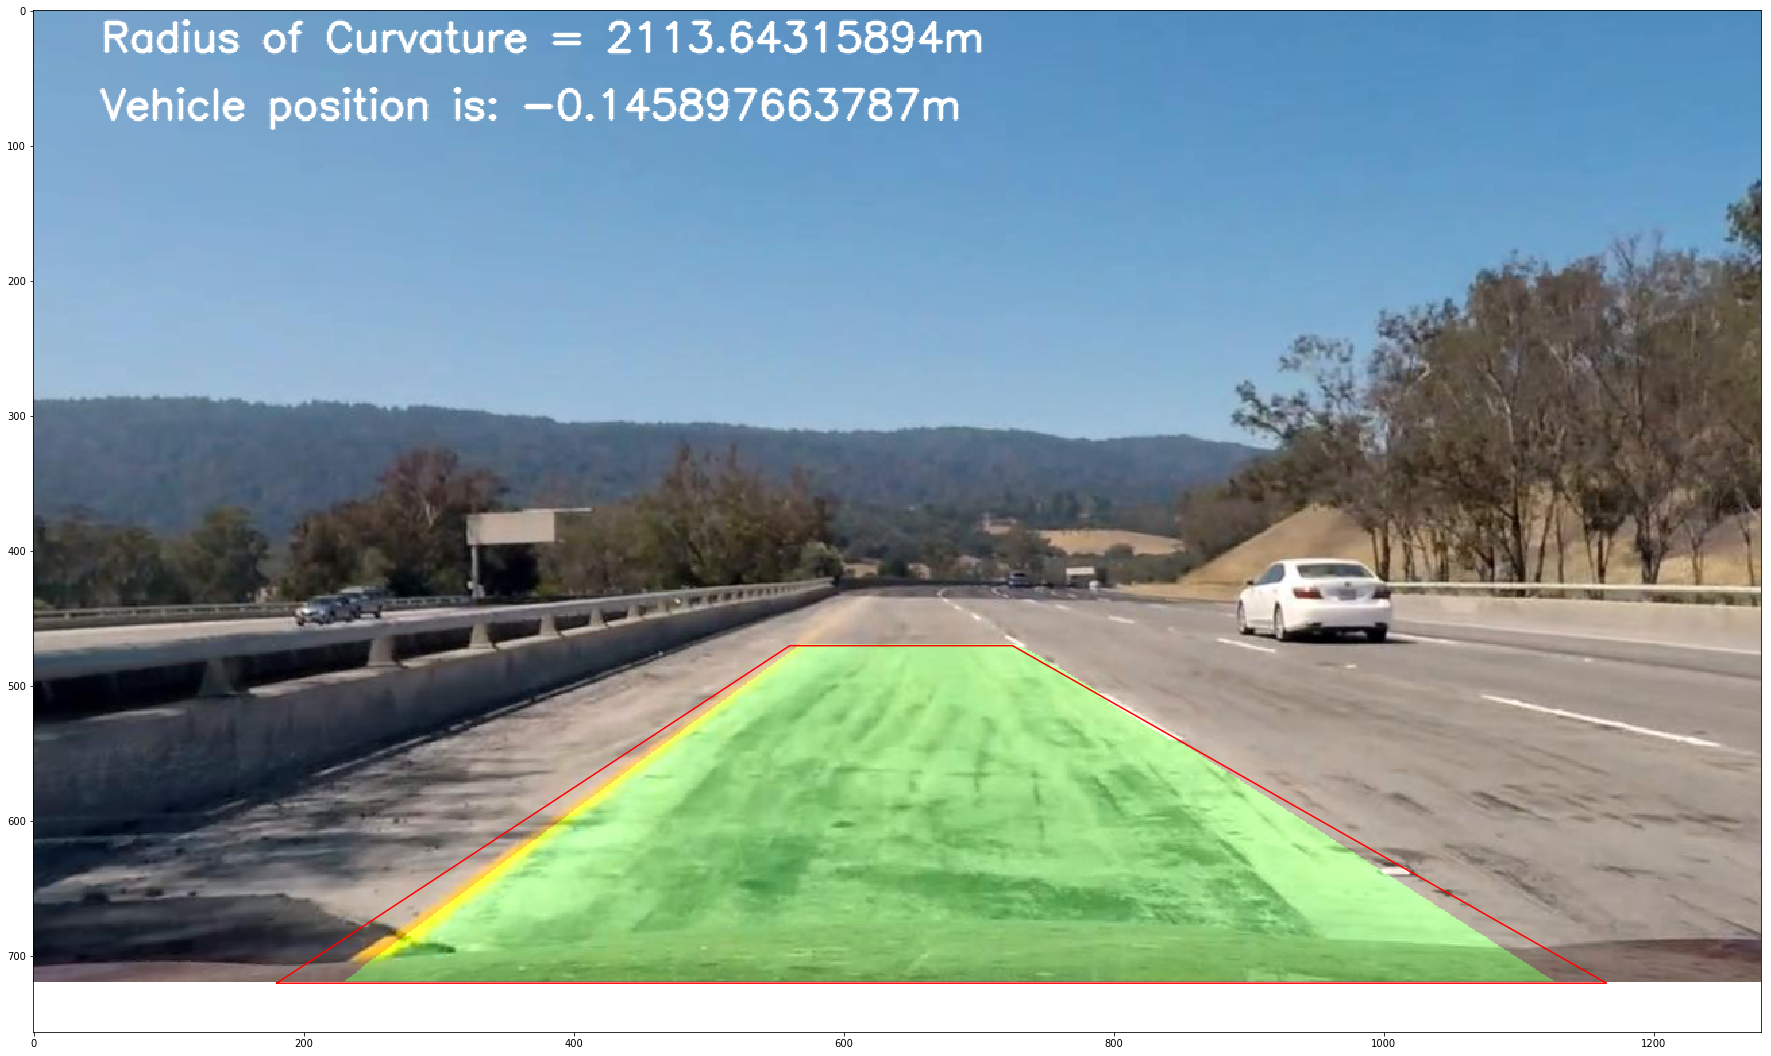

In [364]:
image = mpimg.imread('test_images/test8.jpg')
result = Image_Process(image, Method='Convolution', First_Frame=True)
f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result)
ax1.plot([src[i][0] for i in range(len(src))]+[src[0][0]], 
         [src[i][1] for i in range(len(src))]+[src[0][1]], 'r-')

plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)         

[MoviePy] >>>> Building video Output_Video/project_video.mp4
[MoviePy] Writing video Output_Video/project_video.mp4







  0%|          | 0/1261 [00:00<?, ?it/s]




  0%|          | 1/1261 [00:00<06:04,  3.46it/s]




  0%|          | 2/1261 [00:00<06:26,  3.26it/s]




  0%|          | 3/1261 [00:00<06:15,  3.35it/s]




  0%|          | 4/1261 [00:01<05:55,  3.53it/s]




  0%|          | 5/1261 [00:01<05:13,  4.00it/s]




  0%|          | 6/1261 [00:01<04:44,  4.41it/s]




  1%|          | 7/1261 [00:01<04:29,  4.66it/s]




  1%|          | 8/1261 [00:01<04:20,  4.80it/s]




  1%|          | 9/1261 [00:02<04:44,  4.40it/s]




  1%|          | 10/1261 [00:02<05:34,  3.74it/s]




  1%|          | 11/1261 [00:02<05:52,  3.55it/s]




  1%|          | 12/1261 [00:03<06:02,  3.45it/s]




  1%|          | 13/1261 [00:03<06:23,  3.25it/s]




  1%|          | 14/1261 [00:03<05:57,  3.49it/s]




  1%|          | 15/1261 [00:04<06:06,  3.40it/s]




  1%|▏         | 16/1261 [00:04<05:19,  3.90it/s]




  1%|▏         | 17/1261 [00:04<04:48,  4.31it/s]







  1%|▏         | 18/1261 [00:04<04:52,

 10%|▉         | 124/1261 [00:27<03:47,  4.99it/s]



 10%|▉         | 125/1261 [00:28<03:55,  4.82it/s]



 10%|▉         | 126/1261 [00:28<03:56,  4.80it/s]



 10%|█         | 127/1261 [00:28<03:53,  4.86it/s]



 10%|█         | 128/1261 [00:28<03:49,  4.93it/s]



 10%|█         | 129/1261 [00:28<03:50,  4.91it/s]



 10%|█         | 130/1261 [00:29<03:47,  4.98it/s]



 10%|█         | 131/1261 [00:29<04:04,  4.62it/s]



 10%|█         | 132/1261 [00:29<04:07,  4.57it/s]



 11%|█         | 133/1261 [00:29<04:16,  4.40it/s]



 11%|█         | 134/1261 [00:30<04:13,  4.44it/s]



 11%|█         | 135/1261 [00:30<04:00,  4.68it/s]



 11%|█         | 136/1261 [00:30<03:48,  4.92it/s]



 11%|█         | 137/1261 [00:30<03:42,  5.05it/s]



 11%|█         | 138/1261 [00:30<03:38,  5.13it/s]



 11%|█         | 139/1261 [00:31<03:41,  5.06it/s]



 11%|█         | 140/1261 [00:31<03:33,  5.25it/s]



 11%|█         | 141/1261 [00:31<03:38,  5.14it/s]



 11%|█▏        | 142/1261 [0

 20%|█▉        | 248/1261 [00:56<03:35,  4.71it/s]



 20%|█▉        | 249/1261 [00:57<03:29,  4.84it/s]



 20%|█▉        | 250/1261 [00:57<03:24,  4.95it/s]



 20%|█▉        | 251/1261 [00:57<03:17,  5.10it/s]



 20%|█▉        | 252/1261 [00:57<03:10,  5.29it/s]



 20%|██        | 253/1261 [00:57<03:06,  5.40it/s]



 20%|██        | 254/1261 [00:57<03:05,  5.43it/s]



 20%|██        | 255/1261 [00:58<03:03,  5.50it/s]



 20%|██        | 256/1261 [00:58<03:50,  4.37it/s]



 20%|██        | 257/1261 [00:58<04:12,  3.98it/s]



 20%|██        | 258/1261 [00:59<04:32,  3.68it/s]



 21%|██        | 259/1261 [00:59<04:44,  3.52it/s]



 21%|██        | 260/1261 [00:59<04:56,  3.37it/s]



 21%|██        | 261/1261 [00:59<04:41,  3.55it/s]



 21%|██        | 262/1261 [01:00<04:29,  3.71it/s]



 21%|██        | 263/1261 [01:00<04:21,  3.82it/s]



 21%|██        | 264/1261 [01:00<04:22,  3.79it/s]



 21%|██        | 265/1261 [01:00<04:02,  4.12it/s]



 21%|██        | 266/1261 [0

 30%|██▉       | 372/1261 [01:29<03:55,  3.77it/s]



 30%|██▉       | 373/1261 [01:29<03:40,  4.03it/s]



 30%|██▉       | 374/1261 [01:30<03:58,  3.72it/s]



 30%|██▉       | 375/1261 [01:30<03:40,  4.01it/s]



 30%|██▉       | 376/1261 [01:30<03:30,  4.21it/s]



 30%|██▉       | 377/1261 [01:30<03:17,  4.49it/s]



 30%|██▉       | 378/1261 [01:31<03:16,  4.50it/s]



 30%|███       | 379/1261 [01:31<03:08,  4.68it/s]



 30%|███       | 380/1261 [01:31<03:19,  4.42it/s]



 30%|███       | 381/1261 [01:31<03:19,  4.41it/s]



 30%|███       | 382/1261 [01:32<03:17,  4.44it/s]



 30%|███       | 383/1261 [01:32<03:07,  4.69it/s]



 30%|███       | 384/1261 [01:32<03:07,  4.69it/s]



 31%|███       | 385/1261 [01:32<02:56,  4.95it/s]



 31%|███       | 386/1261 [01:32<02:58,  4.89it/s]



 31%|███       | 387/1261 [01:32<02:54,  5.02it/s]



 31%|███       | 388/1261 [01:33<03:12,  4.54it/s]



 31%|███       | 389/1261 [01:33<03:18,  4.39it/s]



 31%|███       | 390/1261 [0

 39%|███▉      | 496/1261 [02:03<03:02,  4.18it/s]



 39%|███▉      | 497/1261 [02:03<03:07,  4.07it/s]



 39%|███▉      | 498/1261 [02:03<02:57,  4.30it/s]



 40%|███▉      | 499/1261 [02:03<02:52,  4.43it/s]



 40%|███▉      | 500/1261 [02:04<03:11,  3.98it/s]



 40%|███▉      | 501/1261 [02:04<03:00,  4.22it/s]



 40%|███▉      | 502/1261 [02:04<03:00,  4.21it/s]



 40%|███▉      | 503/1261 [02:04<02:52,  4.40it/s]



 40%|███▉      | 504/1261 [02:05<03:23,  3.71it/s]



 40%|████      | 505/1261 [02:05<03:13,  3.91it/s]



 40%|████      | 506/1261 [02:05<03:04,  4.08it/s]



 40%|████      | 507/1261 [02:05<02:56,  4.27it/s]



 40%|████      | 508/1261 [02:06<03:03,  4.10it/s]



 40%|████      | 509/1261 [02:06<03:06,  4.02it/s]



 40%|████      | 510/1261 [02:06<03:21,  3.72it/s]



 41%|████      | 511/1261 [02:06<03:22,  3.70it/s]



 41%|████      | 512/1261 [02:07<03:40,  3.40it/s]



 41%|████      | 513/1261 [02:07<03:49,  3.26it/s]



 41%|████      | 514/1261 [0

 49%|████▉     | 620/1261 [02:33<02:35,  4.12it/s]



 49%|████▉     | 621/1261 [02:34<02:28,  4.30it/s]



 49%|████▉     | 622/1261 [02:34<02:39,  4.02it/s]



 49%|████▉     | 623/1261 [02:34<02:59,  3.56it/s]



 49%|████▉     | 624/1261 [02:35<03:29,  3.04it/s]



 50%|████▉     | 625/1261 [02:35<03:07,  3.39it/s]



 50%|████▉     | 626/1261 [02:35<03:15,  3.24it/s]



 50%|████▉     | 627/1261 [02:35<02:51,  3.71it/s]



 50%|████▉     | 628/1261 [02:36<02:34,  4.09it/s]



 50%|████▉     | 629/1261 [02:36<02:32,  4.16it/s]



 50%|████▉     | 630/1261 [02:36<02:27,  4.28it/s]



 50%|█████     | 631/1261 [02:36<02:20,  4.50it/s]



 50%|█████     | 632/1261 [02:36<02:17,  4.58it/s]



 50%|█████     | 633/1261 [02:37<02:15,  4.63it/s]



 50%|█████     | 634/1261 [02:37<02:10,  4.79it/s]



 50%|█████     | 635/1261 [02:37<02:11,  4.76it/s]



 50%|█████     | 636/1261 [02:37<02:40,  3.90it/s]



 51%|█████     | 637/1261 [02:38<02:28,  4.19it/s]



 51%|█████     | 638/1261 [0

 59%|█████▉    | 744/1261 [03:00<01:49,  4.74it/s]



 59%|█████▉    | 745/1261 [03:00<01:45,  4.90it/s]



 59%|█████▉    | 746/1261 [03:00<01:49,  4.72it/s]



 59%|█████▉    | 747/1261 [03:00<01:45,  4.86it/s]



 59%|█████▉    | 748/1261 [03:00<01:43,  4.96it/s]



 59%|█████▉    | 749/1261 [03:01<01:39,  5.13it/s]



 59%|█████▉    | 750/1261 [03:01<01:39,  5.14it/s]



 60%|█████▉    | 751/1261 [03:01<01:37,  5.24it/s]



 60%|█████▉    | 752/1261 [03:01<01:35,  5.31it/s]



 60%|█████▉    | 753/1261 [03:01<01:33,  5.45it/s]



 60%|█████▉    | 754/1261 [03:01<01:33,  5.44it/s]



 60%|█████▉    | 755/1261 [03:02<01:36,  5.24it/s]



 60%|█████▉    | 756/1261 [03:02<01:46,  4.73it/s]



 60%|██████    | 757/1261 [03:02<02:08,  3.93it/s]



 60%|██████    | 758/1261 [03:03<02:15,  3.72it/s]



 60%|██████    | 759/1261 [03:03<02:17,  3.65it/s]



 60%|██████    | 760/1261 [03:03<02:17,  3.64it/s]



 60%|██████    | 761/1261 [03:04<02:36,  3.20it/s]



 60%|██████    | 762/1261 [0

 69%|██████▉   | 868/1261 [03:30<01:20,  4.90it/s]



 69%|██████▉   | 869/1261 [03:30<01:18,  5.02it/s]



 69%|██████▉   | 870/1261 [03:31<01:18,  4.99it/s]



 69%|██████▉   | 871/1261 [03:31<01:17,  5.05it/s]



 69%|██████▉   | 872/1261 [03:31<01:18,  4.94it/s]



 69%|██████▉   | 873/1261 [03:31<01:15,  5.12it/s]



 69%|██████▉   | 874/1261 [03:31<01:15,  5.14it/s]



 69%|██████▉   | 875/1261 [03:32<01:14,  5.20it/s]



 69%|██████▉   | 876/1261 [03:32<01:15,  5.10it/s]



 70%|██████▉   | 877/1261 [03:32<01:15,  5.10it/s]



 70%|██████▉   | 878/1261 [03:32<01:15,  5.08it/s]



 70%|██████▉   | 879/1261 [03:32<01:13,  5.16it/s]



 70%|██████▉   | 880/1261 [03:33<01:22,  4.61it/s]



 70%|██████▉   | 881/1261 [03:33<01:21,  4.64it/s]



 70%|██████▉   | 882/1261 [03:33<01:23,  4.52it/s]



 70%|███████   | 883/1261 [03:33<01:20,  4.69it/s]



 70%|███████   | 884/1261 [03:33<01:19,  4.76it/s]



 70%|███████   | 885/1261 [03:34<01:16,  4.93it/s]



 70%|███████   | 886/1261 [0

 79%|███████▊  | 992/1261 [04:00<01:30,  2.97it/s]



 79%|███████▊  | 993/1261 [04:00<01:29,  2.99it/s]



 79%|███████▉  | 994/1261 [04:00<01:29,  2.99it/s]



 79%|███████▉  | 995/1261 [04:01<01:29,  2.96it/s]



 79%|███████▉  | 996/1261 [04:01<01:20,  3.31it/s]



 79%|███████▉  | 997/1261 [04:01<01:12,  3.64it/s]



 79%|███████▉  | 998/1261 [04:01<01:06,  3.96it/s]



 79%|███████▉  | 999/1261 [04:02<01:02,  4.20it/s]



 79%|███████▉  | 1000/1261 [04:02<00:59,  4.37it/s]



 79%|███████▉  | 1001/1261 [04:02<01:10,  3.69it/s]



 79%|███████▉  | 1002/1261 [04:02<01:06,  3.89it/s]



 80%|███████▉  | 1003/1261 [04:03<01:01,  4.17it/s]



 80%|███████▉  | 1004/1261 [04:03<00:57,  4.44it/s]



 80%|███████▉  | 1005/1261 [04:03<00:59,  4.27it/s]



 80%|███████▉  | 1006/1261 [04:03<00:55,  4.59it/s]



 80%|███████▉  | 1007/1261 [04:03<00:53,  4.76it/s]



 80%|███████▉  | 1008/1261 [04:04<00:50,  4.97it/s]



 80%|████████  | 1009/1261 [04:04<00:49,  5.09it/s]



 80%|████████  | 1

 88%|████████▊ | 1114/1261 [04:30<00:40,  3.63it/s]



 88%|████████▊ | 1115/1261 [04:30<00:37,  3.89it/s]



 89%|████████▊ | 1116/1261 [04:30<00:35,  4.06it/s]



 89%|████████▊ | 1117/1261 [04:30<00:33,  4.27it/s]



 89%|████████▊ | 1118/1261 [04:30<00:32,  4.44it/s]



 89%|████████▊ | 1119/1261 [04:31<00:30,  4.61it/s]



 89%|████████▉ | 1120/1261 [04:31<00:32,  4.29it/s]



 89%|████████▉ | 1121/1261 [04:31<00:32,  4.26it/s]



 89%|████████▉ | 1122/1261 [04:31<00:31,  4.36it/s]



 89%|████████▉ | 1123/1261 [04:32<00:33,  4.12it/s]



 89%|████████▉ | 1124/1261 [04:32<00:35,  3.89it/s]



 89%|████████▉ | 1125/1261 [04:32<00:34,  3.94it/s]



 89%|████████▉ | 1126/1261 [04:32<00:34,  3.87it/s]



 89%|████████▉ | 1127/1261 [04:33<00:33,  4.01it/s]



 89%|████████▉ | 1128/1261 [04:33<00:32,  4.12it/s]



 90%|████████▉ | 1129/1261 [04:33<00:30,  4.26it/s]



 90%|████████▉ | 1130/1261 [04:33<00:31,  4.12it/s]



 90%|████████▉ | 1131/1261 [04:34<00:30,  4.31it/s]



 90%|█████

 98%|█████████▊| 1236/1261 [04:59<00:07,  3.50it/s]



 98%|█████████▊| 1237/1261 [04:59<00:06,  3.45it/s]



 98%|█████████▊| 1238/1261 [04:59<00:06,  3.70it/s]



 98%|█████████▊| 1239/1261 [05:00<00:05,  3.82it/s]



 98%|█████████▊| 1240/1261 [05:00<00:05,  4.03it/s]



 98%|█████████▊| 1241/1261 [05:00<00:04,  4.28it/s]



 98%|█████████▊| 1242/1261 [05:00<00:04,  4.39it/s]



 99%|█████████▊| 1243/1261 [05:01<00:03,  4.50it/s]



 99%|█████████▊| 1244/1261 [05:01<00:03,  4.56it/s]



 99%|█████████▊| 1245/1261 [05:01<00:03,  4.77it/s]



 99%|█████████▉| 1246/1261 [05:01<00:03,  4.74it/s]



 99%|█████████▉| 1247/1261 [05:01<00:02,  4.69it/s]



 99%|█████████▉| 1248/1261 [05:02<00:02,  4.71it/s]



 99%|█████████▉| 1249/1261 [05:02<00:02,  4.72it/s]



 99%|█████████▉| 1250/1261 [05:02<00:02,  4.65it/s]



 99%|█████████▉| 1251/1261 [05:02<00:02,  4.28it/s]



 99%|█████████▉| 1252/1261 [05:03<00:02,  4.35it/s]



 99%|█████████▉| 1253/1261 [05:03<00:01,  4.63it/s]



 99%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_Video/project_video.mp4 



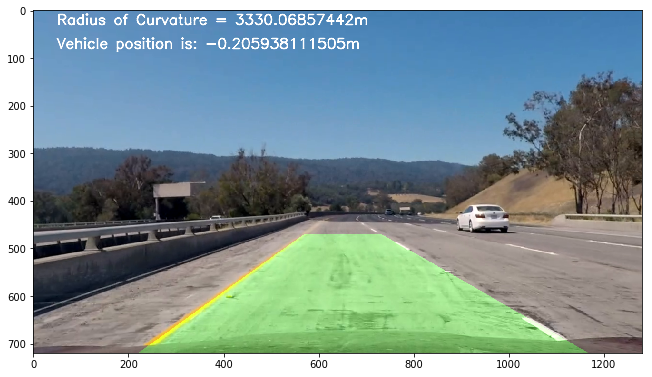

In [365]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

previous_frames.clear()
Output = 'Output_Video/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("project_video.mp4")

frame = clip1.get_frame(23)
result_first = Image_Process(frame, First_Frame=True)
# print (previous_frames)
# frame = clip1.get_frame(23.7)
# result_first = Image_Process(frame, First_Frame=False)
f1 = plt.figure(figsize=(24,9))
plt.subplot(121)
plt.imshow(result_first)
# print (Left_Right_Fit)


# plt.subplot(122)
# result_second = Image_Process(frame)
# plt.imshow(result_second)
# print (Left_Right_Fit)
# clip1.save_frame('test_images/test8.jpg',t=3.2)

Clip = clip1.fl_image(Image_Process) #NOTE: this function expects color images!!
Clip.write_videofile(Output, audio=False)

In [300]:
# #challenge video
# previous_frames.clear()
# Output2 = 'Output_Video/challenge_video.mp4'
# clip2 = VideoFileClip("challenge_video.mp4").subclip(0,5)

# frame = clip1.get_frame(0)
# result_first = Image_Process(frame, First_Frame = True)

# Clip = clip2.fl_image(Image_Process) #NOTE: this function expects color images!!
# Clip.write_videofile(Output2, audio=False)

[MoviePy] >>>> Building video Output/challenge_video.mp4
[MoviePy] Writing video Output/challenge_video.mp4








  0%|          | 0/150 [00:00<?, ?it/s]





  1%|          | 1/150 [00:00<00:25,  5.81it/s]





  1%|▏         | 2/150 [00:00<00:25,  5.83it/s]





  2%|▏         | 3/150 [00:00<00:24,  6.06it/s]





  3%|▎         | 4/150 [00:00<00:23,  6.17it/s]





  3%|▎         | 5/150 [00:00<00:22,  6.31it/s]





  4%|▍         | 6/150 [00:00<00:22,  6.38it/s]





  5%|▍         | 7/150 [00:01<00:22,  6.45it/s]





  5%|▌         | 8/150 [00:01<00:22,  6.41it/s]





  6%|▌         | 9/150 [00:01<00:21,  6.59it/s]





  7%|▋         | 10/150 [00:01<00:22,  6.25it/s]





  7%|▋         | 11/150 [00:01<00:22,  6.32it/s]





  8%|▊         | 12/150 [00:01<00:22,  6.12it/s]





  9%|▊         | 13/150 [00:02<00:22,  6.13it/s]





  9%|▉         | 14/150 [00:02<00:22,  6.02it/s]





 10%|█         | 15/150 [00:02<00:22,  6.00it/s]





 11%|█         | 16/150 [00:02<00:21,  6.17it/s]





 11%|█▏        | 17/150 [00:02<00:21,  6.29it/s]





 12%|█▏        | 18/150 [00:02<00:20,  6

 75%|███████▌  | 113/150 [00:18<00:06,  5.62it/s]





 76%|███████▌  | 114/150 [00:18<00:06,  5.67it/s]





 77%|███████▋  | 115/150 [00:18<00:06,  5.68it/s]





 77%|███████▋  | 116/150 [00:19<00:05,  5.89it/s]





 78%|███████▊  | 117/150 [00:19<00:05,  6.10it/s]





 79%|███████▊  | 118/150 [00:19<00:05,  6.22it/s]





 79%|███████▉  | 119/150 [00:19<00:04,  6.59it/s]





 80%|████████  | 120/150 [00:19<00:04,  6.76it/s]





 81%|████████  | 121/150 [00:19<00:04,  7.03it/s]





 81%|████████▏ | 122/150 [00:19<00:03,  7.21it/s]





 82%|████████▏ | 123/150 [00:20<00:03,  7.19it/s]





 83%|████████▎ | 124/150 [00:20<00:03,  7.32it/s]





 83%|████████▎ | 125/150 [00:20<00:03,  7.32it/s]





 84%|████████▍ | 126/150 [00:20<00:03,  7.45it/s]





 85%|████████▍ | 127/150 [00:20<00:03,  7.50it/s]





 85%|████████▌ | 128/150 [00:20<00:03,  6.95it/s]





 86%|████████▌ | 129/150 [00:20<00:03,  6.60it/s]





 87%|████████▋ | 130/150 [00:21<00:03,  6.17it/s]





 87%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: Output/challenge_video.mp4 

